Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-denoising.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-denoising.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel simple pour le denoising.

Cet exemple est censé être lu après avoir lu l'exemple "mnist", dont il est directement dérivé. Seuls les parties différentes sont commentées.

<br>
<br>
<br>
Imports des librairies, paramètres généraux et définition du jeu de données. Cette partie est quasi inchangée, seul le paramètre num_classes est supprimé ici, car on ne se trouve plus dans un problème de classification (les classes ne joueront aucun rôle).

In [204]:
#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Hyper parameters
num_epochs = 5
batch_size = 16
learning_rate = 0.001 #0.0001

device: cuda:0


In [205]:
# dataset d'images
dataset = "Imagenette" # "MNIST" #

if dataset == "MNIST":
    train_dataset = torchvision.datasets.MNIST(root='data/', train=True,
                                              transform=transforms.ToTensor(),
                                              download=True)
    test_dataset = torchvision.datasets.MNIST(root='data/', train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)
    n_channels = 1
elif dataset == "Imagenette":
    transform=transforms.Compose([transforms.ToTensor(),
                                transforms.RandomCrop(size=(20,32),pad_if_needed=True)])
    train_dataset = torchvision.datasets.Imagenette(root='data/', split="train",
                                                   transform=transform,
                                                   download=True)
    test_dataset = torchvision.datasets.Imagenette(root='data/', split="val",
                                                  transform=transform,
                                                  download=True)
    n_channels = 3

In [206]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

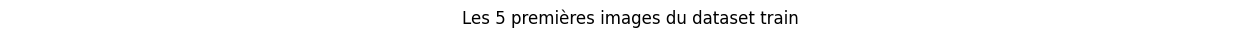

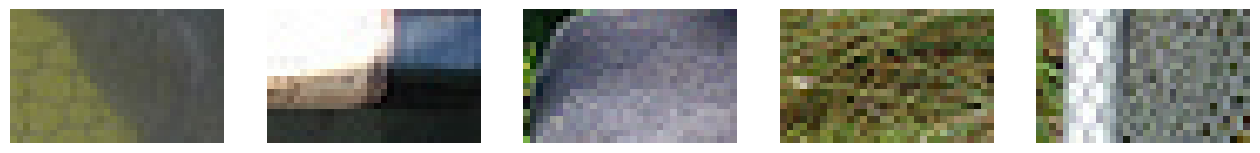

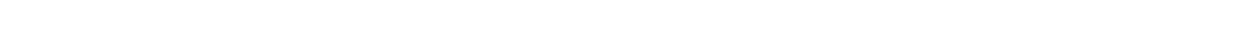

In [207]:
# affichage de quelques images
def show_images(images, nrows=1, title=None):
    nb_ims = images.shape[0]
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    ncols = math.ceil(nb_ims/nrows)
    for k in range(nb_ims):
       plt.subplot(nrows, ncols, k+1)
       plt.imshow(images[k].permute((1,2,0)), cmap="gray")
       plt.axis("off")
    plt.show()
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.3))
    plt.axis("off")
    plt.show()

def load_batch(dataset, n):
  return torch.stack([dataset[k][0] for k in range(n)])

train_images_sample = load_batch(train_dataset, 5)
show_images(train_images_sample, title="Les 5 premières images du dataset train")

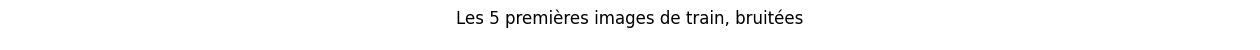

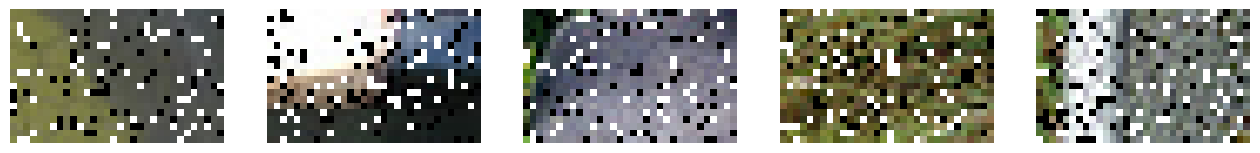

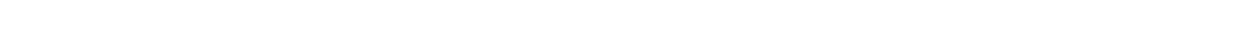

In [208]:
# une fonction pour ajouter du bruit
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone().permute((0,2,3,1))
    rnd = torch.rand(images_noisy.shape[:-1])
    images_noisy[rnd<prob,:] = 0
    images_noisy[rnd>1-prob,:] = 1
    return images_noisy.permute((0,3,1,2))

train_images_sample_noisy = salt_and_pepper(train_images_sample)
show_images(train_images_sample_noisy, title="Les 5 premières images de train, bruitées")

<br>
<br>
<br>
Définition du réseau.

In [209]:
# Réseau CNN
class ConvNet(nn.Module):
    def __init__(self, n_channels):
        super(ConvNet, self).__init__()
        self.op = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=2))

            nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, n_channels, kernel_size=5, stride=1, padding=2),
            #nn.BatchNorm2d(n_channels),
            #nn.ReLU(),

            nn.Sigmoid()
        )

    def forward(self, x):
        # encoding
        out = self.op(x)
        return out

model = ConvNet(n_channels).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

<br>
<br>
<br>
Entraînement du réseau. Ici la seule mais fondamentale différence est que la fonction coût évalue la différence
entre la sortie du réseau et les images d''entrée, et non plus entre la sortie et les classes.
Ici le critère utilisé est celui des moindres carrés.

In [210]:
# Entraînement du réseau
lossfun = nn.BCELoss()
print("beginning training...")
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        images_noisy = salt_and_pepper(images)

        # Forward pass
        outputs = model(images_noisy)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")

beginning training...
Epoch [1/5], Step [100/592], Loss: 0.5332
Epoch [1/5], Step [200/592], Loss: 0.5664
Epoch [1/5], Step [300/592], Loss: 0.6065
Epoch [1/5], Step [400/592], Loss: 0.5365
Epoch [1/5], Step [500/592], Loss: 0.6057
Epoch [2/5], Step [100/592], Loss: 0.5498
Epoch [2/5], Step [200/592], Loss: 0.5715
Epoch [2/5], Step [300/592], Loss: 0.4049
Epoch [2/5], Step [400/592], Loss: 0.4661
Epoch [2/5], Step [500/592], Loss: 0.5280
Epoch [3/5], Step [100/592], Loss: 0.4775
Epoch [3/5], Step [200/592], Loss: 0.5444
Epoch [3/5], Step [300/592], Loss: 0.4937
Epoch [3/5], Step [400/592], Loss: 0.5001
Epoch [3/5], Step [500/592], Loss: 0.5173
Epoch [4/5], Step [100/592], Loss: 0.5175
Epoch [4/5], Step [200/592], Loss: 0.5088
Epoch [4/5], Step [300/592], Loss: 0.5743
Epoch [4/5], Step [400/592], Loss: 0.5751
Epoch [4/5], Step [500/592], Loss: 0.4836
Epoch [5/5], Step [100/592], Loss: 0.4619
Epoch [5/5], Step [200/592], Loss: 0.4849
Epoch [5/5], Step [300/592], Loss: 0.5303
Epoch [5/5],

<br>
<br>
<br>
On affiche la sortie du réseau pour cinq images test. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça.

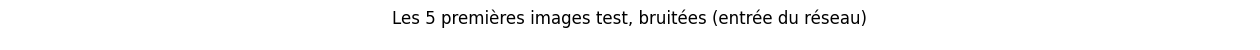

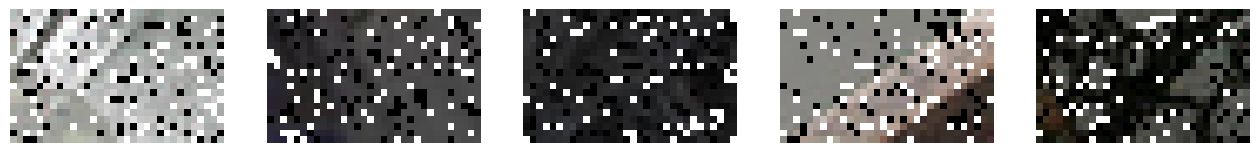

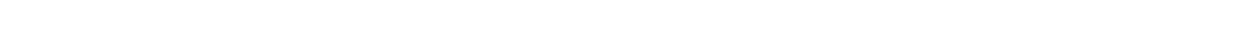

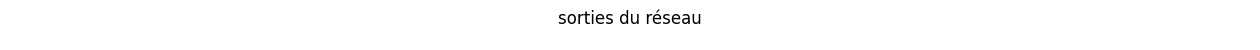

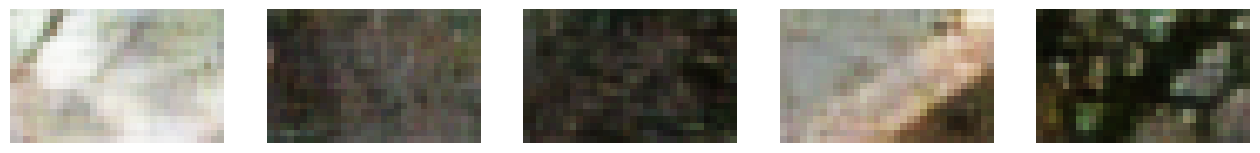

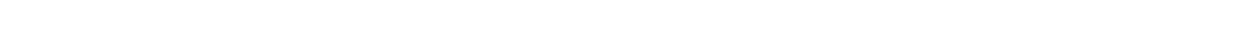

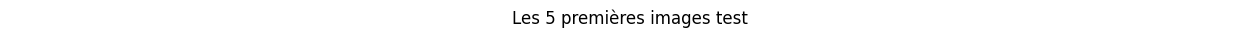

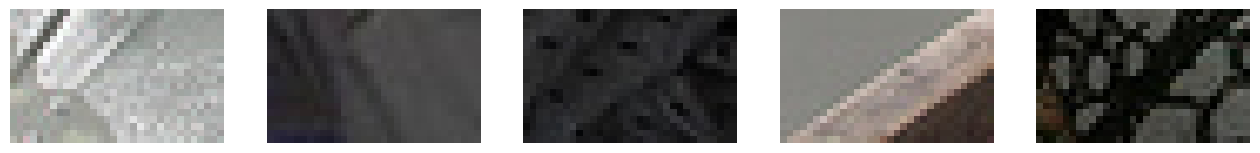

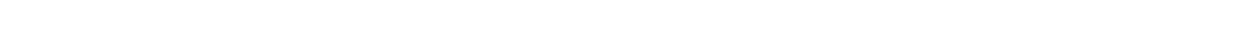

In [212]:
test_images_sample = load_batch(test_dataset, 5)
test_images_sample_noisy = salt_and_pepper(test_images_sample)

outputs = model(test_images_sample_noisy.to(device)).detach().cpu()

show_images(test_images_sample_noisy, title="Les 5 premières images test, bruitées (entrée du réseau)")
show_images(outputs, title="sorties du réseau")
show_images(test_images_sample, title="Les 5 premières images test")